# Clasificación de Imagenes usando el Conjunto de Datos CIFAR-10

Usaremos un conjunto de datos estandarizado llamado CIFAR-10. CIFAR-10 consta de 60000 imágenes. Hay 10 categorías diferentes y 6000 imágenes por categoría. Cada imagen tiene un tamaño de solo 32 por 32 píxeles. El tamaño pequeño hace que a veces sea dificil para los humanos reconocer la categoría correcta, pero simplifica las cosas para nuestro modelo de aprendizaje automático y reduce la carga computacional requerida para analizar las imágenes.

<img src="figuras/CIFAR-10_examples.png" width="75%">

La forma en que ingresamos estas imágenes en nuestro modelo es alimentando el modelo con una serie de números. Cada píxel se describe mediante tres números de coma flotante que representan los valores rojo, verde y azul para ese píxel. Esto da como resultado un total de 32 x 32 x 3 = 3072 valores para cada imagen.

<img src="figuras/representacion_imagen.png" width="75%">

## Crear una Red Neuronal de Dos Capas

Conjunto de datos CIFAR-10: descargue la versión Python del conjunto de datos de :https://www.cs.toronto.edu/~kriz/cifar.html o use el [enlace directo](https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz) al archivo comprimido. Coloque el directorio extraído `cifar-10-batches-py/` en el directorio donde están colocandos los datos del notebook, de modo que la ruta a las imágenes sea `/ruta-a-su-directorio-datos/cifar-10-batches-py/`. En nuestro ejemplo la ruta es `datos/cifar-10-batches-py/`.

In [1]:
import numpy as np
import tensorflow as tf
import time
import pickle

/Users/wladimir/anaconda/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


Funciones de utilidad para cargar los datos de CIFAR-10 y para codificación one-hot

In [2]:
def cargar_lote_CIFAR10(nombre_archivo):
  '''carga los datos de un archivo CIFAR-10'''
  with open(nombre_archivo, 'rb') as archivo:
    diccionario = pickle.load(archivo, encoding='latin1')
    x = diccionario['data']
    y = diccionario['labels']
    x = x.astype(float)
    y = np.array(y)
  return x, y

def cargar_datos():
  '''carga los datos de todos los archivos CIFAR-10 y mezcla los lotes de entrenamiento'''

  xs = []
  ys = []
  for i in range(1, 6):
    nombre_archivo = 'datos/cifar-10-batches-py/data_batch_' + str(i)
    X, Y = cargar_lote_CIFAR10(nombre_archivo)
    xs.append(X)
    ys.append(Y)

  x_entrenamiento = np.concatenate(xs)
  y_entrenamiento = np.concatenate(ys)
  del xs, ys

  x_prueba, y_prueba = cargar_lote_CIFAR10('datos/cifar-10-batches-py/test_batch')

  clases = ['avión', 'carro', 'pajaro', 'gato', 'venado', 'perro', 'rana', 'caballo',
    'barco', 'camión']

  diccionario_datos = {
    'imagenes_entrenamiento': x_entrenamiento,
    'etiquetas_entrenamiento': y_entrenamiento,
    'imagenes_prueba': x_prueba,
    'etiquetas_prueba': y_prueba,
    'clases': clases
  }
  return diccionario_datos

def onehot(y, n_clases):
        """Codificar etiquetas en representación one-hot

        Parámetros
        ------------
        y : array, shape = [n_muestras]
            Target values.

        Retorna
        -----------
        onehot : array, shape = (n_muestras, n_etiquetas)

        """
        onehot = np.zeros((n_clases, y.shape[0]))
        for idx, val in enumerate(y.astype(int)):
            onehot[val, idx] = 1.
        return onehot.T

Cargar los datos y codificar las etiquetas usando "one-hot"

In [3]:
# Inicializar la semilla del generado de numeros aleatorios
# para obtener los mismos datos para todas las corridas
np.random.seed(1)

# Preparar los datos
conjunto_datos = cargar_datos()
print(conjunto_datos['imagenes_entrenamiento'].shape)
print(conjunto_datos['etiquetas_entrenamiento'].shape)
print(conjunto_datos['imagenes_prueba'].shape)
print(conjunto_datos['etiquetas_prueba'].shape)
y_entrenamiento = onehot(conjunto_datos['etiquetas_entrenamiento'], 10)
y_prueba = onehot(conjunto_datos['etiquetas_prueba'], 10)
print(y_entrenamiento.shape)
print(y_prueba.shape)

(50000, 3072)
(50000,)
(10000, 3072)
(10000,)
(50000, 10)
(10000, 10)


`cargar_datos()` devuelve un diccionario que contiene:

- imagenes_entrenamiento: el conjunto de datos de entrenamiento como una matriz de valores de 50000 por 3072 (= 32 píxeles x 32 píxeles x 3 canales de color).
- etiquetas_entrenamiento: 50000 etiquetas para el conjunto de entrenamiento (cada una representa un número entre 0 y 9 representando a cuál de las 10 clases pertenece la imagen de entrenamiento)
- imagenes_prueba: conjunto de prueba (10000 por 3072)
- etiquetas_prueba: 10000 etiquetas para el conjunto de prueba
- clases: 10 etiquetas de texto para traducir el valor numérico de clase en una palabra (0 para 'avión', 1 para 'carro', etc.)

### Visualizar algunas de las imágenes del Conjunto de Prueba 

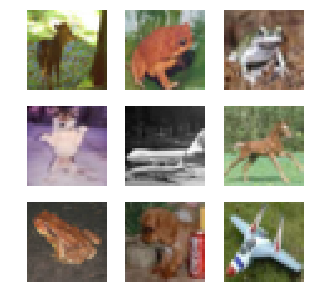

In [5]:
%matplotlib inline
np.random.seed(3)
import matplotlib.pyplot as plt
# Visualización CIFAR 10
X = conjunto_datos['imagenes_prueba'].reshape(10000, 3, 32, 32).transpose(0,2,3,1).astype("uint8")
fig, axes1 = plt.subplots(3,3,figsize=(5,5))
for j in range(3):
    for k in range(3):
        i = np.random.choice(range(len(X)))
        axes1[j][k].set_axis_off()
        axes1[j][k].imshow(X[i:i+1][0])

Normalizar las imágenes de entrenamiento y de prueba

In [6]:
  # Normalizar los Datos
  media_imagen = np.mean(conjunto_datos['imagenes_entrenamiento'], axis=0)
  conjunto_datos['imagenes_entrenamiento'] -= media_imagen
  conjunto_datos['imagenes_prueba'] -= media_imagen

### Arquitectura de la Red Neuronal

Vamos a crear una Red Neuronal con dos capas ocultas, cada capa oculta constará de 120 nodos, la capa de entrada es de 30172 nodos y la de salida de 10 nodos:

<img src="figuras/RedNeuronalCIFAR-10.png" width="75%">

### Inicializar variables y "placeholders"

A continuación, podemos configurar las variables de marcador de posición para los datos de entrenamiento

In [7]:
# Preparar el grafo de TensorFlow

# Definición de hiperparámetros
tamaño_lote = 100
tasa_aprendizaje = 0.005
epocas = 100
nodos_capa_oculta_1 = 120
nodos_capa_oculta_2 = 120

# Definir los placeholders para las entradas
with tf.name_scope('entrada'):
    x = tf.placeholder(tf.float32, shape=[None, 3072], name="imagenes")
    y = tf.placeholder(tf.float32, shape=[None, 10], name="etiquetas")

Ahora necesitamos configurar las variables de pesos y sesgo para la red neuronal de tres capas. Siempre hay un número $L-1$ de tensores de pesos/sesgo, donde $L$ es el número de capas. Entonces, en este caso, necesitamos configurar dos tensores para cada uno:

In [8]:
with tf.name_scope('pesos'):
    # declarar los pesos conectando la capa de entrada con la capa oculta 1
    W1 = tf.Variable(tf.random_normal([3072, nodos_capa_oculta_1], stddev=0.03), name='W1')
    # declarar los pesos conectando la capa oculta 1 con la capa oculta 2
    W2 = tf.Variable(tf.random_normal([nodos_capa_oculta_1, nodos_capa_oculta_2], stddev=0.03), name='W2')
    # y los pesos conectando la capa oculta 2 con la capa de salidad
    W3 = tf.Variable(tf.random_normal([nodos_capa_oculta_2, 10], stddev=0.03), name='W3')
    
with tf.name_scope('sesgos'):
    b1 = tf.Variable(tf.random_normal([nodos_capa_oculta_1]), name='b1')
    b2 = tf.Variable(tf.random_normal([nodos_capa_oculta_2]), name='b2')
    b3 = tf.Variable(tf.random_normal([10]), name='b3')

A continuación, tenemos que configurar las entradas netas a los nodos y las funciones de activación de los nodos de capa oculta:

In [9]:
with tf.name_scope('capa_oculta_1'):
    # calcular la activación de la capa oculta 1
    oculta_1_entrada = tf.add(tf.matmul(x, W1), b1)
    oculta_1_activacion = tf.nn.relu(oculta_1_entrada)

with tf.name_scope('capa_oculta_2'):
    # calcular la activación de la capa oculta 2
    oculta_2_entrada = tf.add(tf.matmul(oculta_1_activacion, W2), b2)
    oculta_2_activacion = tf.nn.relu(oculta_2_entrada)

Ahora, configuremos la capa de salida, `activacion_salida`:

In [10]:
with tf.name_scope('capa_salida'):
    # calcular la activación de la capa de salida - usando la función de activación softmax
    activacion_salida = tf.nn.softmax(tf.add(tf.matmul(oculta_2_activacion, W3), b3))

También debemos incluir una función de costo o pérdida para poder realizar la propagación hacia atrás. Aquí usaremos la función de costo de entropía cruzada, representada por:

$$J(\boldsymbol{w})=-\frac{1}{m}\sum_{i=1}^{m}\sum_{j=1}^{n}y^{[i]}log(a^{[i]}_j)+(1-y^{[i]}_j)log(1-a^{[i]}_j)$$

Podemos implementar esta función de costo de entropía cruzada en TensorFlow con el siguiente código:

In [11]:
with tf.name_scope('entropia_cruzada'):
    activacion_salida_cortada = tf.clip_by_value(activacion_salida, 1e-10, 0.9999999)
    entropia_cruzada = -tf.reduce_mean(tf.reduce_sum(y * tf.log(activacion_salida_cortada)
                         + (1 - y) * tf.log(1 - activacion_salida_cortada), axis=1))

Ahora vamos a configurar el optimizador en TensorFlow:

In [12]:
with tf.name_scope('entrenamiento'):
    # agregar un optimizador
    optimizador = tf.train.GradientDescentOptimizer(learning_rate=tasa_aprendizaje).minimize(entropia_cruzada)

Finalmente configuremos la operación de inicialización variable y una operación para medir la precisión de nuestras predicciones:

In [13]:
# inicializar las variables
inicializar = tf.global_variables_initializer()

with tf.name_scope('Exactitud'):
    # definir la operación de exactitud
    prediccion_corecta = tf.equal(tf.argmax(y, 1), tf.argmax(activacion_salida, 1))
    exactitud = tf.reduce_mean(tf.cast(prediccion_corecta, tf.float32))

Función de utilidad para generar lote de datos de entrenamineto

In [14]:
def obtener_proximo_lote(lote, batch_size=tamaño_lote):
    lote_x = conjunto_datos["imagenes_entrenamiento"][i*tamaño_lote:(i+1)*tamaño_lote]
    lote_y = y_entrenamiento[i*tamaño_lote:(i+1)*tamaño_lote]
    return lote_x, lote_y

Ahora tenemos todo lo que necesitamos para configurar el proceso de entrenamiento de nuestra red neuronal

In [15]:
# agregar un resumen para almacenar la precisión
tf.summary.scalar('costo', entropia_cruzada)
tf.summary.scalar('exactitud', exactitud)

unir = tf.summary.merge_all()
escritor = tf.summary.FileWriter("cifar", graph=tf.get_default_graph())

Este es el grafo generado para la Red Neuronal:

<img src='figuras/cifar-10_grafo.png' width="75%">

In [16]:
tiempoInicio = time.time()
# arrancar la sesión
with tf.Session() as sess:
    # inicializar las variables
    sess.run(inicializar)
    total_lotes = int(len(conjunto_datos["imagenes_entrenamiento"]) / tamaño_lote)
    for epoca in range(epocas):
        costo_promedio = 0
        for i in range(total_lotes):
            lote_x, lote_y = obtener_proximo_lote(lote=i, batch_size=tamaño_lote)
            _, c = sess.run([optimizador, entropia_cruzada], feed_dict={x: lote_x, y: lote_y})
            costo_promedio += c / total_lotes
        print("Epoca:", (epoca + 1), "costo =", "{:.3f}".format(costo_promedio))
        sumario = sess.run(unir, feed_dict={x: conjunto_datos["imagenes_entrenamiento"], y: y_entrenamiento})
        escritor.add_summary(sumario, epoca)

    tiempoFin = time.time()
    print("\nEntrenamiento finalizado!")
    print('Tiempo Total: {:5.2f}s'.format(tiempoFin - tiempoInicio))
    escritor.add_graph(sess.graph)
    print("Exactitud Entrenamiento: ",sess.run(exactitud, feed_dict={x: conjunto_datos["imagenes_entrenamiento"], y: y_entrenamiento}))
    print("Exactitud Prueba: ",sess.run(exactitud, feed_dict={x: conjunto_datos["imagenes_prueba"], y: y_prueba}))

Epoca: 1 costo = 3.340
Epoca: 2 costo = 2.560
Epoca: 3 costo = 2.443
Epoca: 4 costo = 2.353
Epoca: 5 costo = 2.279
Epoca: 6 costo = 2.212
Epoca: 7 costo = 2.153
Epoca: 8 costo = 2.100
Epoca: 9 costo = 2.046
Epoca: 10 costo = 1.995
Epoca: 11 costo = 1.951
Epoca: 12 costo = 1.910
Epoca: 13 costo = 1.871
Epoca: 14 costo = 1.830
Epoca: 15 costo = 1.796
Epoca: 16 costo = 1.760
Epoca: 17 costo = 1.729
Epoca: 18 costo = 1.708
Epoca: 19 costo = 1.679
Epoca: 20 costo = 1.650
Epoca: 21 costo = 1.633
Epoca: 22 costo = 1.603
Epoca: 23 costo = 1.590
Epoca: 24 costo = 1.560
Epoca: 25 costo = 1.550
Epoca: 26 costo = 1.519
Epoca: 27 costo = 1.506
Epoca: 28 costo = 1.491
Epoca: 29 costo = 1.472
Epoca: 30 costo = 1.452
Epoca: 31 costo = 1.450
Epoca: 32 costo = 1.409
Epoca: 33 costo = 1.410
Epoca: 34 costo = 1.396
Epoca: 35 costo = 1.384
Epoca: 36 costo = 1.364
Epoca: 37 costo = 1.355
Epoca: 38 costo = 1.326
Epoca: 39 costo = 1.328
Epoca: 40 costo = 1.314
Epoca: 41 costo = 1.300
Epoca: 42 costo = 1.283
E

### Gráficos

Gráfico del Costo por Epocas:

<img src='figuras/costo_cifar-10.png' width="75%">

Gráfico de la Exactitud sobre el Conjunto de Entrenamiento por Epocas:

<img src='figuras/exactitud_cifar-10.png' width="75%">